In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from matplotlib.pyplot import figure
import matplotlib as mpl

#Visualization
import seaborn as sns

#Preprocessing
from sklearn.model_selection import train_test_split

#Model Building
from sklearn.tree import DecisionTreeRegressor # to build regression tree
import pmdarima as pmd

#Tree Plotting
from sklearn import tree
from sklearn.tree import plot_tree # to draw the tree

#Accuracy Validation
from sklearn import metrics
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

import multiprocessing

## Bitcoin

### Loading Data

In [8]:
Bitcoin = pd.read_csv("coin_Bitcoin.csv",parse_dates=['Date'])
Bitcoin = Bitcoin.drop(columns=['SNo','Name'])

Bitcoin.isnull().sum()

Symbol       0
Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Marketcap    0
dtype: int64

### Data Preparation

In [9]:
data_week = [0 for i in range(7)]
closes = Bitcoin['Close'].values

for i in closes[:-7]:
    data_week.append(i)

#### Three Week Average Calculation

In [10]:
three_avg = [0,0,0]
for i in range(len(closes)-3):
    three_avg.append((closes[i] + closes[i+1] + closes[i+2])/3)
#print(len(three_avg))
#print(len(closes))
Bitcoin["Three_day_Avg"] = three_avg

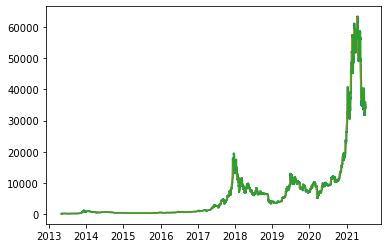

In [11]:
plt.plot(Bitcoin['Date'] , closes)
plt.plot(Bitcoin['Date'] , three_avg)
plt.plot(Bitcoin['Date'] , data_week)

In [12]:
Bitcoin["Date"] = Bitcoin["Date"].dt.strftime('%Y-%m-%d')
Bitcoin["Date"]=pd.to_datetime(Bitcoin["Date"])

In [13]:
Bitcoin['Day'] = Bitcoin['Date'].dt.day_name() 

#### Week Average Calculation

In [14]:
day = Bitcoin['Day'].values

i = 0 
Sum = 0
while day[i] !='Monday':
    Sum+=closes[i]
    i+=1
WeekAvg = [ Sum/(i) for j in range(i)]
print(WeekAvg)
for j in range(i , len(closes)-7, 7):
    Avg = sum(closes[j : j +7])/7
    curr = [Avg for i in range(7)]
    WeekAvg+=curr
for j in range( len(WeekAvg) , len(closes)):
    WeekAvg.append(closes[i])
Bitcoin["Week_Avg"] = WeekAvg

[]


#### Month Average Calculation

In [15]:
Bitcoin['Month'] = Bitcoin['Date'].dt.month

In [16]:
month = Bitcoin['Month'].values
monthavg = []
Sum = closes[0]
n = 1
for i in range(1 , len(month)):
    if month[i] != month[i-1]:
        curr = [Sum/n for j in range(n)]
        monthavg+=curr
        Sum = 0
        n=0
   
    Sum+=closes[i]
    n+=1

curr = [Sum/n for j in range(n)]
monthavg+=curr


Bitcoin['Month_Avg'] = monthavg

In [17]:
Bitcoin['Year'] = Bitcoin["Date"].dt.year
Bitcoin['Month'] = Bitcoin["Date"].dt.month
Bitcoin['Day'] = Bitcoin["Date"].dt.day

<AxesSubplot:title={'center':'Mean Bitcoin Closing Price'}, xlabel='Date'>

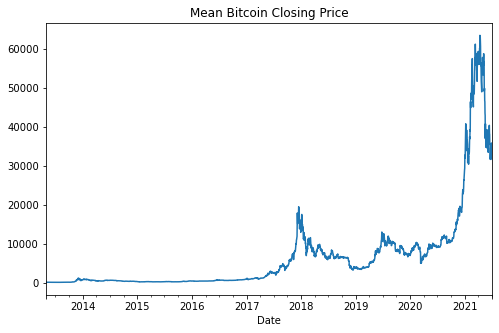

In [18]:
df_grouped = Bitcoin.groupby(["Date"])['Close'].mean()
df_grouped.plot(figsize = (8,5) , title = "Mean Bitcoin Closing Price")

<AxesSubplot:title={'center':'Mean Bitcoin Closing Price'}, xlabel='Year'>

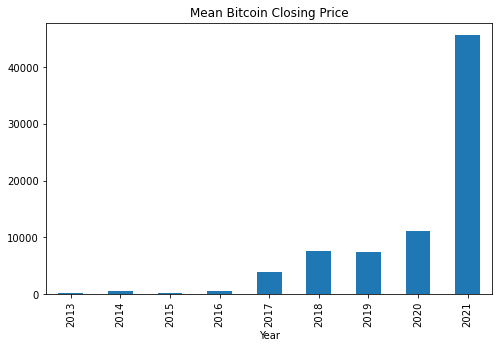

In [19]:
df_year = Bitcoin.groupby(['Year'])['Close'].mean()
df_year.plot.bar(figsize = (8,5),title = "Mean Bitcoin Closing Price")

#### Training/Testing Data Split

In [20]:
X= Bitcoin.drop(columns=['Close','Open','High','Low','Symbol','Volume','Marketcap','Date'])
y= Bitcoin['Close']

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

### Regression

#### Decision Tree Regression

In [22]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(min_samples_leaf=5,random_state=42)
tree_reg.fit(X_train, y_train)

y_train_pred = tree_reg.predict(X_train)

print("MSE:", metrics.mean_squared_error(y_train, y_train_pred, squared=False))
print("R Squared:", metrics.r2_score(y_train, y_train_pred))

MSE: 468.22600524814226
R Squared: 0.9983326294315676


In [23]:
param_grid = {
    'splitter': ['best','random'],
    'max_depth': [1,2,3,4,5,6,7,8,9],
    'min_samples_split': [2,3,4,5,6],
    'min_samples_leaf': [1,2,3,4,5,6]
}
dtr_gs = GridSearchCV(estimator=DecisionTreeRegressor() , param_grid=param_grid)

dtr_gs.fit(X_train, y_train)

dtr_gs_best = dtr_gs.best_estimator_
dtr_gs_best.fit(X_train,y_train)

print('Best model: %s' % str(dtr_gs.best_params_))
print('Best score: %f' % dtr_gs.best_score_)
print('Best test auc: %f' % dtr_gs_best.score(X_test,y_test))

Best model: {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}
Best score: 0.996424
Best test auc: 0.996810


In [24]:
import math

tree_reg = DecisionTreeRegressor(max_depth = 16, min_samples_leaf = 2, min_samples_split = 4, splitter = 'best')
tree_reg.fit(X_train, y_train)

y_test_pred = tree_reg.predict(X_test)

MSE = metrics.mean_squared_error(y_test, y_test_pred, squared=False)

RSquared = metrics.r2_score(y_test, y_test_pred)

RMSE = math.sqrt(MSE)

print("MSE:",MSE)
print("R Squared:",RSquared)
print("RMSE:",RMSE)

MSE: 664.7924695072426
R Squared: 0.996308117416549
RMSE: 25.78356975880653


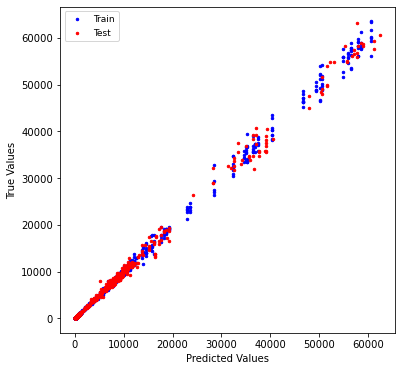

In [25]:
fig, ax = plt.subplots(figsize=(6, 6))

mpl.rcParams['font.size'] = 9
mpl.rcParams['axes.linewidth'] = 0

ax.scatter(y_train_pred,y_train,color='blue', s=6, label = "Train")

ax.scatter(y_test_pred,y_test,color='red', s=6, label = "Test")


ax.set_xlabel("Predicted Values", fontsize=10)
ax.set_ylabel("True Values", fontsize=10)
ax.legend()

#### Linear Regression

In [26]:
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

y_train_pred = linear_reg.predict(X_train)
y_test_pred = linear_reg.predict(X_test)

MSE = metrics.mean_squared_error(y_test, y_test_pred, squared=False)

RSquared = metrics.r2_score(y_test, y_test_pred)

RMSE = math.sqrt(MSE)

print("MSE:",MSE)
print("R Squared:",RSquared)
print("RMSE:",RMSE)

MSE: 610.3487724695236
R Squared: 0.9968880554595271
RMSE: 24.705237753754236


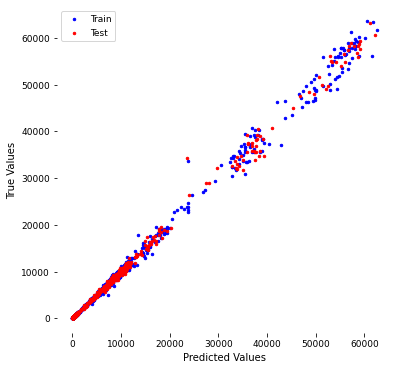

In [27]:
fig, ax = plt.subplots(figsize=(6, 6))

#mpl.rcParams['font.size'] = 5
mpl.rcParams['axes.linewidth'] = 0

ax.scatter(y_train_pred,y_train,color='blue', s=6, label = "Train")

ax.scatter(y_test_pred,y_test,color='red', s=6, label = "Test")


ax.set_xlabel("Predicted Values", fontsize=10)
ax.set_ylabel("True Values", fontsize=10)
ax.legend()

#### Bayesian Ridge

In [28]:
from sklearn.linear_model  import BayesianRidge

br_reg = BayesianRidge()

br_reg .fit(X_train, y_train)

y_train_pred = br_reg.predict(X_train)
y_test_pred = br_reg.predict(X_test)

MSE = metrics.mean_squared_error(y_test, y_test_pred, squared=False)

RSquared = metrics.r2_score(y_test, y_test_pred)

RMSE = math.sqrt(MSE)

print("MSE:",MSE)
print("R Squared:",RSquared)
print("RMSE:",RMSE)

MSE: 610.4566509049464
R Squared: 0.9968869552971557
RMSE: 24.707420968303154


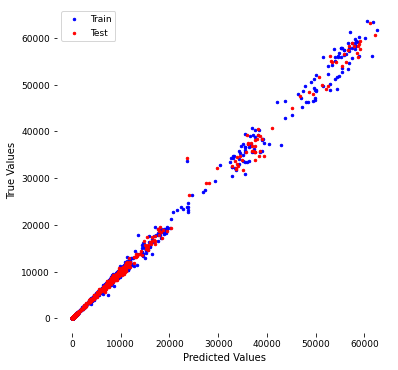

In [29]:
fig, ax = plt.subplots(figsize=(6, 6))

#mpl.rcParams['font.size'] = 5
mpl.rcParams['axes.linewidth'] = 0

ax.scatter(y_train_pred,y_train,color='blue', s=6, label = "Train")

ax.scatter(y_test_pred,y_test,color='red', s=6, label = "Test")


ax.set_xlabel("Predicted Values", fontsize=10)
ax.set_ylabel("True Values", fontsize=10)
ax.legend()

### Bitcoin Time Series (ARIMA)

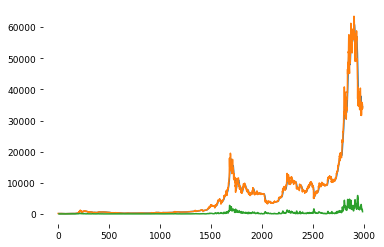

In [30]:
rollmean = Bitcoin["Close"].rolling(10).mean()
plt.plot(rollmean)

plt.plot(Bitcoin["Close"])

plt.plot(Bitcoin["Close"].rolling(10).std()) #not stationary 

In [31]:
Close_scaled = Bitcoin['Close']

Close_scaled = Close_scaled.arrays
Close_scaled.shape

(2991,)

In [32]:
Close_scaled = Close_scaled.reshape(-1,1)

In [33]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(Close_scaled)

Close_scaled = scaler.transform(Close_scaled)

Close_scaled = Close_scaled.reshape(2991,)

In [34]:
Close_scaled = pd.Series(Close_scaled)
Bitcoin['Close_scaled'] = Close_scaled

In [35]:
Data_Arima = Bitcoin.set_index('Date')
closeTrain = Data_Arima['Close_scaled'][:-24]
closeTest = Data_Arima['Close_scaled'][-24:]
print(len(closeTest))
print(len(closeTrain))

closeTrain

24
2967


Date
2013-04-29    0.001200
2013-04-30    0.001112
2013-05-01    0.000765
2013-05-02    0.000580
2013-05-03    0.000462
                ...   
2021-06-08    0.526589
2021-06-09    0.587636
2021-06-10    0.577507
2021-06-11    0.587467
2021-06-12    0.559377
Name: Close_scaled, Length: 2967, dtype: float64

In [36]:
adf = pmd.arima.ADFTest(alpha = 0.05)
adf.should_diff(Data_Arima['Close'])
#data is already station

(0.7664133686043878, True)

In [37]:
#model = pmd.arima.auto_arima(closeTrain, start_p=0, d=1, start_q=0, max_p=5, max_d=5, max_q=5, start_P=0, D=1, start_Q=0, max_P=5,max_D=5, max_Q=5, m=12, seasonal=True, error_action='warn', trace=True, supress_warnings=True,stepwise=True,random_state=20,n_fits=50)
model = pmd.arima.auto_arima(closeTrain, error_action='ignore', seasonal = True)
model.fit(closeTrain)
y_pred = model.predict(n_periods = len(closeTest))
print(len(y_pred))
Y_pred = pd.DataFrame(y_pred , index = closeTest.index , columns = ["Pred"])                          

24


<Figure size 432x288 with 0 Axes>

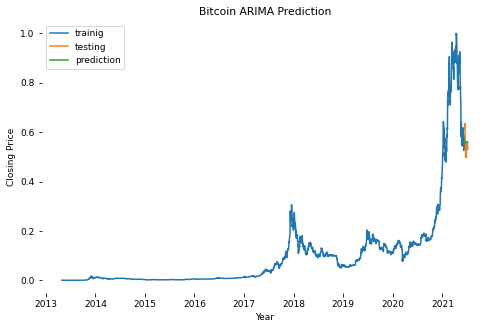

In [38]:
fig = plt.figure()
fig, ax = plt.subplots(figsize = (8,5))

ax.plot(closeTrain , label = "trainig")
ax.plot(closeTest, label = "testing")
ax.plot(Y_pred, label = "prediction")
ax.set_xlabel('Year')
ax.set_ylabel('Closing Price')
ax.set_title("Bitcoin ARIMA Prediction")
ax.legend()

In [39]:
MSE = metrics.mean_squared_error(closeTest, Y_pred, squared=False)

RSquared = metrics.r2_score(closeTest, Y_pred)

RMSE = math.sqrt(MSE)

print("MSE:",MSE)
print("R Squared:",RSquared)
print("RMSE:",RMSE)

MSE: 0.037873652777966706
R Squared: 0.005192043402034163
RMSE: 0.1946115432803684


## XRP

### Loading Data

In [40]:
XRP = pd.read_csv("coin_XRP.csv")
XRP = XRP.drop(columns=['SNo','Name'])

XRP.isnull().sum()

Symbol       0
Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Marketcap    0
dtype: int64

### Data Preparation

In [41]:
import datetime as dt

XRP["Date"]=pd.to_datetime(XRP["Date"])
XRP["Date"] = XRP["Date"].dt.strftime('%Y-%m-%d')
XRP["Date"]=pd.to_datetime(XRP["Date"])

#### Three Week Average Calculation

In [42]:
data_week = [0 for i in range(7)]
closes = XRP['Close'].values

for i in closes[:-7]:
    data_week.append(i)

In [43]:
three_avg = [0,0,0]
for i in range(len(closes)-3):
    three_avg.append((closes[i] + closes[i+1] + closes[i+2])/3)
#print(len(three_avg))
#print(len(closes))
XRP["Three_day_Avg"] = three_avg

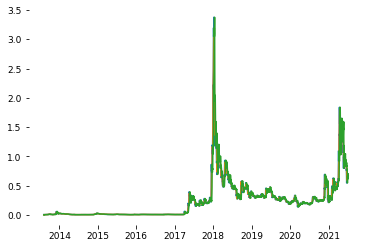

In [44]:
plt.plot(XRP['Date'] , closes)
plt.plot(XRP['Date'] , three_avg)
plt.plot(XRP['Date'] , data_week)

#### Week Average Calculation

In [45]:
XRP['Day'] = XRP['Date'].dt.day_name()

In [46]:
day = XRP['Day'].values

i = 0 
Sum = 0
while day[i] !='Monday':
    Sum+=closes[i]
    i+=1
WeekAvg = [ Sum/(i) for j in range(i)]
print(WeekAvg)
for j in range(i , len(closes)-7, 7):
    Avg = sum(closes[j : j +7])/7
    curr = [Avg for i in range(7)]
    WeekAvg+=curr
for j in range( len(WeekAvg) , len(closes)):
    WeekAvg.append(closes[i])
XRP["Week_Avg"] = WeekAvg

[]


#### Month Average Calculation

In [47]:
XRP['Month'] = XRP['Date'].dt.month

In [48]:
month = XRP['Month'].values
monthavg = []
Sum = closes[0]
n = 1
for i in range(1 , len(month)):
    if month[i] != month[i-1]:
        curr = [Sum/n for j in range(n)]
        monthavg+=curr
        Sum = 0
        n=0
   
    Sum+=closes[i]
    n+=1

curr = [Sum/n for j in range(n)]
monthavg+=curr


XRP['Month_Avg'] = monthavg

In [49]:
XRP['Year'] = XRP["Date"].dt.year
XRP['Month'] = XRP["Date"].dt.month
XRP['Day'] = XRP["Date"].dt.day

<AxesSubplot:title={'center':'Mean XRP Closing Price'}, xlabel='Date'>

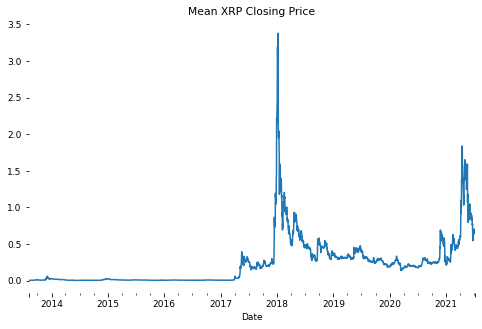

In [50]:
df_grouped = XRP.groupby(["Date"])['Close'].mean()
df_grouped.plot(figsize = (8,5) , title = "Mean XRP Closing Price")

<AxesSubplot:title={'center':'Mean XRP Closing Price'}, xlabel='Year'>

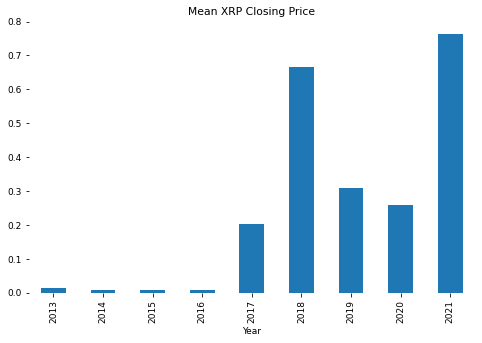

In [51]:
df_year = XRP.groupby(['Year'])['Close'].mean()
df_year.plot.bar(figsize = (8,5) ,title = "Mean XRP Closing Price")

#### Training/Testing Data Split

In [52]:
X= XRP.drop(columns=['Close','Open','High','Low','Symbol','Volume','Marketcap','Date'])
y= XRP['Close']

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

### Regression

#### Decision Tree Regression

In [54]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(min_samples_leaf=5,random_state=42)
tree_reg.fit(X_train, y_train)

y_train_pred = tree_reg.predict(X_train)

print("MSE:", metrics.mean_squared_error(y_train, y_train_pred, squared=False))
print("R Squared:", metrics.r2_score(y_train, y_train_pred))

MSE: 0.0381231807531713
R Squared: 0.9865390144924696


In [55]:
param_grid = {
    'splitter': ['best','random'],
    'max_depth': [1,2,3,4,5,6,7,8,9],
    'min_samples_split': [2,3,4,5,6],
    'min_samples_leaf': [1,2,3,4,5,6]
}
dtr_gs = GridSearchCV(estimator=DecisionTreeRegressor() , param_grid=param_grid)

dtr_gs.fit(X_train, y_train)

dtr_gs_best = dtr_gs.best_estimator_
dtr_gs_best.fit(X_train,y_train)

print('Best model: %s' % str(dtr_gs.best_params_))
print('Best score: %f' % dtr_gs.best_score_)
print('Best test auc: %f' % dtr_gs_best.score(X_test,y_test))

Best model: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'splitter': 'best'}
Best score: 0.979346
Best test auc: 0.971709


In [56]:
import math

tree_reg = DecisionTreeRegressor(max_depth = 6, min_samples_leaf = 1, min_samples_split = 2, splitter = 'best')
tree_reg.fit(X_train, y_train)

y_test_pred = tree_reg.predict(X_test)

MSE = metrics.mean_squared_error(y_test, y_test_pred, squared=False)

RSquared = metrics.r2_score(y_test, y_test_pred)

RMSE = math.sqrt(MSE)

print("MSE:",MSE)
print("R Squared:",RSquared)
print("RMSE:",RMSE)

MSE: 0.05353967890514609
R Squared: 0.9776298867467774
RMSE: 0.2313864276597616


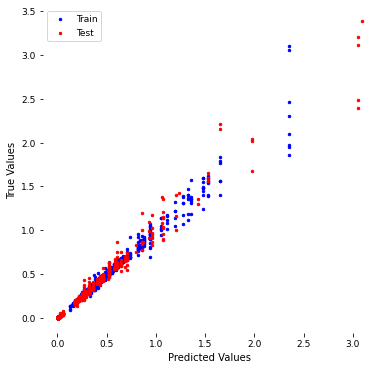

In [57]:
fig, ax = plt.subplots(figsize=(6, 6))

#mpl.rcParams['font.size'] = 5
mpl.rcParams['axes.linewidth'] = 0

ax.scatter(y_train_pred,y_train,color='blue', s=6, label = "Train")

ax.scatter(y_test_pred,y_test,color='red', s=6, label = "Test")


ax.set_xlabel("Predicted Values", fontsize=10)
ax.set_ylabel("True Values", fontsize=10)
ax.legend()

#### Linear Regression

In [58]:
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

y_train_pred = linear_reg.predict(X_train)

y_test_pred = linear_reg.predict(X_test)

MSE = metrics.mean_squared_error(y_test, y_test_pred, squared=False)

RSquared = metrics.r2_score(y_test, y_test_pred)

RMSE = math.sqrt(MSE)

print("MSE:",MSE)
print("R Squared:",RSquared)
print("RMSE:",RMSE)

MSE: 0.051905905402961215
R Squared: 0.9789743127508929
RMSE: 0.2278286755502064


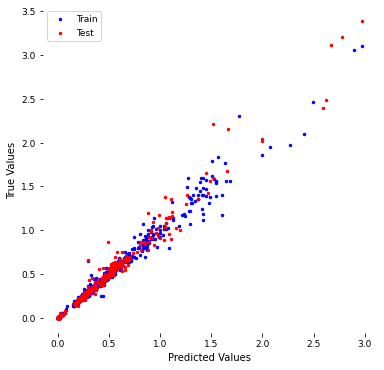

In [59]:
fig, ax = plt.subplots(figsize=(6, 6))

#mpl.rcParams['font.size'] = 5
mpl.rcParams['axes.linewidth'] = 0

ax.scatter(y_train_pred,y_train,color='blue', s=6, label = "Train")

ax.scatter(y_test_pred,y_test,color='red', s=6, label = "Test")


ax.set_xlabel("Predicted Values", fontsize=10)
ax.set_ylabel("True Values", fontsize=10)
ax.legend()

#### Bayesian Ridge

In [60]:
from sklearn.linear_model  import BayesianRidge

br_reg = BayesianRidge()

br_reg .fit(X_train, y_train)

y_train_pred = br_reg.predict(X_train)
y_test_pred = br_reg.predict(X_test)

MSE = metrics.mean_squared_error(y_test, y_test_pred, squared=False)

RSquared = metrics.r2_score(y_test, y_test_pred)

RMSE = math.sqrt(MSE)

print("MSE:",MSE)
print("R Squared:",RSquared)
print("RMSE:",RMSE)

MSE: 0.05192538308089133
R Squared: 0.9789585300225261
RMSE: 0.22787141786738266


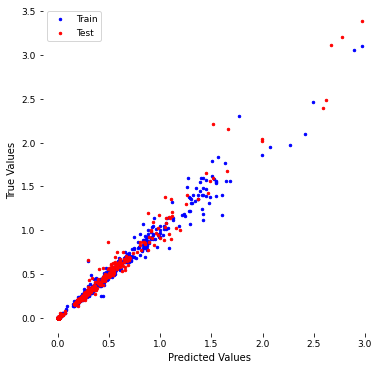

In [61]:
fig, ax = plt.subplots(figsize=(6, 6))

#mpl.rcParams['font.size'] = 5
mpl.rcParams['axes.linewidth'] = 0

ax.scatter(y_train_pred,y_train,color='blue', s=6, label = "Train")

ax.scatter(y_test_pred,y_test,color='red', s=6, label = "Test")


ax.set_xlabel("Predicted Values", fontsize=10)
ax.set_ylabel("True Values", fontsize=10)
ax.legend()

### Time Series (ARIMA)

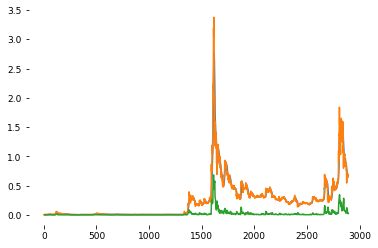

In [62]:
rollmean = XRP["Close"].rolling(10).mean()
plt.plot(rollmean)

plt.plot(XRP["Close"])

plt.plot(XRP["Close"].rolling(10).std()) #not stationary 

In [63]:
Close_scaled = XRP['Close']

Close_scaled = Close_scaled.array
Close_scaled.shape

(2893,)

In [64]:
Close_scaled = Close_scaled.reshape(-1,1)

In [65]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(Close_scaled)

Close_scaled = scaler.transform(Close_scaled)

Close_scaled = Close_scaled.reshape(2893,)

In [66]:
Close_scaled = pd.Series(Close_scaled)
XRP['Close_scaled'] = Close_scaled

In [67]:
Data_Arima = XRP.set_index('Date')
closeTrain = Data_Arima['Close_scaled'][:-12]
closeTest = Data_Arima['Close_scaled'][-12:]
print(len(closeTest))
print(len(closeTrain))

closeTrain

12
2881


Date
2013-08-05    0.000830
2013-08-06    0.000554
2013-08-07    0.000476
2013-08-08    0.000428
2013-08-09    0.000439
                ...   
2021-06-20    0.229205
2021-06-21    0.180023
2021-06-22    0.160669
2021-06-23    0.184807
2021-06-24    0.198278
Name: Close_scaled, Length: 2881, dtype: float64

In [68]:
adf = pmd.arima.ADFTest(alpha = 0.05)
adf.should_diff(Data_Arima['Close'])
#data is already station

(0.01, False)

In [69]:
model = pmd.arima.auto_arima(closeTrain, error_action='ignore', seasonal = True)
model.fit(closeTrain)
y_pred = model.predict(n_periods = len(closeTest))
print(len(y_pred))
Y_pred = pd.DataFrame(y_pred , index = closeTest.index , columns = ["Pred"])    

12


<Figure size 432x288 with 0 Axes>

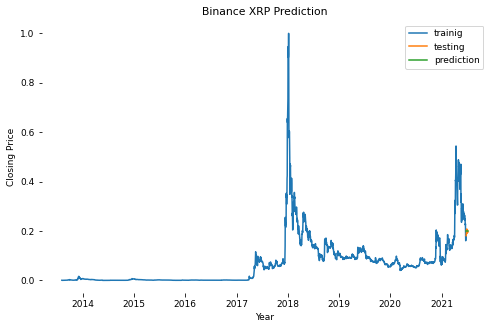

In [70]:
fig = plt.figure()
fig, ax = plt.subplots(figsize = (8,5))

ax.plot(closeTrain , label = "trainig")
ax.plot(closeTest, label = "testing")
ax.plot(Y_pred, label = "prediction")
ax.set_xlabel('Year')
ax.set_ylabel('Closing Price')
ax.set_title("Binance XRP Prediction")
ax.legend()

In [71]:
MSE = metrics.mean_squared_error(closeTest, Y_pred, squared=False)

RSquared = metrics.r2_score(closeTest, Y_pred)

RMSE = math.sqrt(MSE)

print("MSE:",MSE)
print("R Squared:",RSquared)
print("RMSE:",RMSE)

MSE: 0.009119698209109382
R Squared: -0.14387921475401444
RMSE: 0.09549711099875945


## Ethereum

### Loading Data

In [73]:
Ethereum = pd.read_csv("coin_Ethereum.csv")
Ethereum = Ethereum.drop(columns=['SNo','Name'])

Ethereum.isnull().sum()

Symbol       0
Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Marketcap    0
dtype: int64

### Data Preparation

In [74]:
import datetime as dt

Ethereum["Date"]=pd.to_datetime(Ethereum["Date"])
Ethereum["Date"] = Ethereum["Date"].dt.strftime('%Y-%m-%d')
Ethereum["Date"]=pd.to_datetime(Ethereum["Date"])

In [75]:
data_week = [0 for i in range(7)]
closes = Ethereum['Close'].values

for i in closes[:-7]:
    data_week.append(i)

#### Three Week Average Calculation

In [76]:
three_avg = [0,0,0]
for i in range(len(closes)-3):
    three_avg.append((closes[i] + closes[i+1] + closes[i+2])/3)

print(len(three_avg))
print(len(closes))


Ethereum["Three_day_Avg"] = three_avg

2160
2160


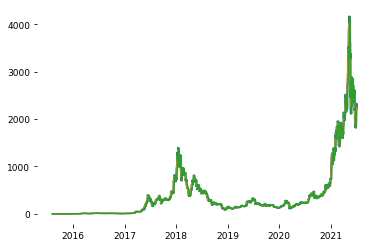

In [77]:
plt.plot(Ethereum['Date'] , closes)
plt.plot(Ethereum['Date'] , three_avg)
plt.plot(Ethereum['Date'] , data_week)

#### Week Average Calculation

In [78]:
Ethereum['Day'] = Ethereum['Date'].dt.day_name()

In [79]:
day = Ethereum['Day'].values

i = 0 
Sum = 0
while day[i] !='Monday':
    Sum+=closes[i]
    i+=1
WeekAvg = [ Sum/(i) for j in range(i)]
print(WeekAvg)
for j in range(i , len(closes)-7, 7):
    Avg = sum(closes[j : j +7])/7
    curr = [Avg for i in range(7)]
    WeekAvg+=curr
for j in range( len(WeekAvg) , len(closes)):
    WeekAvg.append(closes[i])
Ethereum["Week_Avg"] = WeekAvg

[0.7276110053062439, 0.7276110053062439]


#### Month Average Calculation

In [80]:
Ethereum['Month'] = Ethereum['Date'].dt.month

In [81]:
month = Ethereum['Month'].values
monthavg = []
Sum = closes[0]
n = 1
for i in range(1 , len(month)):
    if month[i] != month[i-1]:
        curr = [Sum/n for j in range(n)]
        monthavg+=curr
        Sum = 0
        n=0
   
    Sum+=closes[i]
    n+=1

curr = [Sum/n for j in range(n)]
monthavg+=curr


Ethereum['Month_Avg'] = monthavg

In [82]:
Ethereum['Year'] = Ethereum["Date"].dt.year
Ethereum['Month'] = Ethereum["Date"].dt.month
Ethereum['Day'] = Ethereum["Date"].dt.day

<AxesSubplot:title={'center':'Mean Ethereum Closing Price'}, xlabel='Date'>

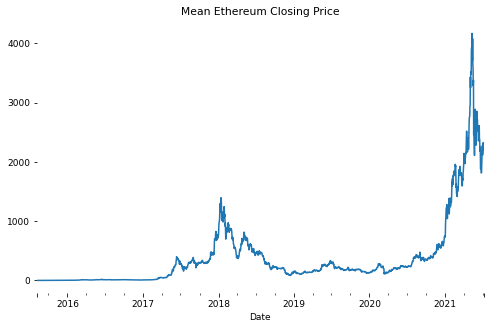

In [83]:
df_grouped = Ethereum.groupby(["Date"])['Close'].mean()
df_grouped.plot(figsize = (8,5) , title = "Mean Ethereum Closing Price")

<AxesSubplot:title={'center':'Mean Ethereum Closing Price'}, xlabel='Year'>

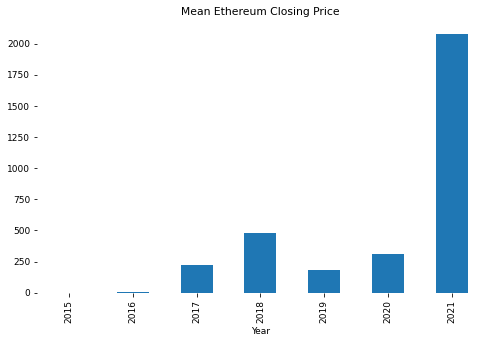

In [84]:
df_year = Ethereum.groupby(['Year'])['Close'].mean()
df_year.plot.bar(figsize = (8,5) ,title = "Mean Ethereum Closing Price")

#### Training/Testing Data Split

In [85]:
X= Ethereum.drop(columns=['Close','Open','High','Low','Symbol','Volume','Marketcap','Date'])
y= Ethereum['Close']

In [86]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

### Regression

#### Decision Tree Regression

In [87]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(min_samples_leaf=5,random_state=42)
tree_reg.fit(X_train, y_train)

y_train_pred = tree_reg.predict(X_train)

print("MSE:", metrics.mean_squared_error(y_train, y_train_pred, squared=False))
print("R Squared:", metrics.r2_score(y_train, y_train_pred))

MSE: 41.054319787713496
R Squared: 0.9957289610352534


In [88]:
param_grid = {
    'splitter': ['best','random'],
    'max_depth': [1,2,3,4,5,6,7,8,9],
    'min_samples_split': [2,3,4,5,6],
    'min_samples_leaf': [1,2,3,4,5,6]
}
dtr_gs = GridSearchCV(estimator=DecisionTreeRegressor() , param_grid=param_grid)

dtr_gs.fit(X_train, y_train)

dtr_gs_best = dtr_gs.best_estimator_
dtr_gs_best.fit(X_train,y_train)

print('Best model: %s' % str(dtr_gs.best_params_))
print('Best score: %f' % dtr_gs.best_score_)
print('Best test auc: %f' % dtr_gs_best.score(X_test,y_test))

Best model: {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'random'}
Best score: 0.991278
Best test auc: 0.993382


In [89]:
import math

tree_reg = DecisionTreeRegressor(max_depth = 6, min_samples_leaf = 1, min_samples_split = 4, splitter = 'best')
tree_reg.fit(X_train, y_train)

y_test_pred = tree_reg.predict(X_test)

MSE = metrics.mean_squared_error(y_test, y_test_pred, squared=False)

RSquared = metrics.r2_score(y_test, y_test_pred)

RMSE = math.sqrt(MSE)

print("MSE:",MSE)
print("R Squared:",RSquared)
print("RMSE:",RMSE)

MSE: 52.28017791883225
R Squared: 0.9906434068530033
RMSE: 7.230503296371024


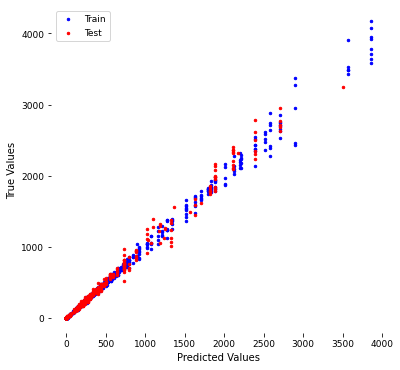

In [90]:
fig, ax = plt.subplots(figsize=(6, 6))

#mpl.rcParams['font.size'] = 5
mpl.rcParams['axes.linewidth'] = 0

ax.scatter(y_train_pred,y_train,color='blue', s=6, label = "Train")

ax.scatter(y_test_pred,y_test,color='red', s=6, label = "Test")


ax.set_xlabel("Predicted Values", fontsize=10)
ax.set_ylabel("True Values", fontsize=10)
ax.legend()

#### Linear Regression

In [91]:
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

y_train_pred = linear_reg.predict(X_train)
y_test_pred = linear_reg.predict(X_test)

MSE = metrics.mean_squared_error(y_test, y_test_pred, squared=False)

RSquared = metrics.r2_score(y_test, y_test_pred)

RMSE = math.sqrt(MSE)

print("MSE:",MSE)
print("R Squared:",RSquared)
print("RMSE:",RMSE)

MSE: 34.180568457402686
R Squared: 0.9960005322970537
RMSE: 5.846415008995058


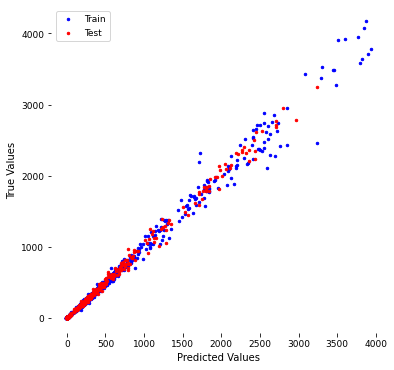

In [92]:
fig, ax = plt.subplots(figsize=(6, 6))

#mpl.rcParams['font.size'] = 5
mpl.rcParams['axes.linewidth'] = 0

ax.scatter(y_train_pred,y_train,color='blue', s=6, label = "Train")

ax.scatter(y_test_pred,y_test,color='red', s=6, label = "Test")


ax.set_xlabel("Predicted Values", fontsize=10)
ax.set_ylabel("True Values", fontsize=10)
ax.legend()

#### Bayesian Ridge

In [93]:
from sklearn.linear_model  import BayesianRidge

br_reg = BayesianRidge()
br_reg .fit(X_train, y_train)

y_train_pred = br_reg.predict(X_train)
y_test_pred = br_reg.predict(X_test)

MSE = metrics.mean_squared_error(y_test, y_test_pred, squared=False)

RSquared = metrics.r2_score(y_test, y_test_pred)

RMSE = math.sqrt(MSE)

print("MSE:",MSE)
print("R Squared:",RSquared)
print("RMSE:",RMSE)

MSE: 34.1502856752008
R Squared: 0.9960076159333426
RMSE: 5.843824576011912


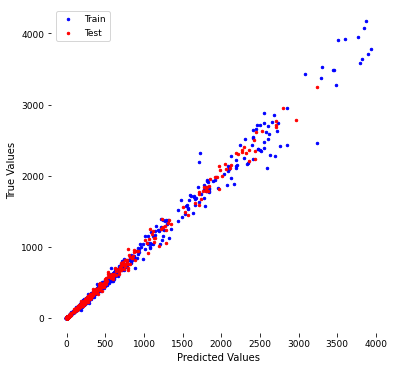

In [94]:
fig, ax = plt.subplots(figsize=(6, 6))

#mpl.rcParams['font.size'] = 5
mpl.rcParams['axes.linewidth'] = 0

ax.scatter(y_train_pred,y_train,color='blue', s=6, label = "Train")

ax.scatter(y_test_pred,y_test,color='red', s=6, label = "Test")


ax.set_xlabel("Predicted Values", fontsize=10)
ax.set_ylabel("True Values", fontsize=10)
ax.legend()

### Time Series (ARIMA)

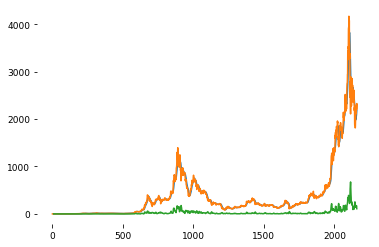

In [95]:
rollmean = Ethereum["Close"].rolling(10).mean()
plt.plot(rollmean)

plt.plot(Ethereum["Close"])

plt.plot(Ethereum["Close"].rolling(10).std()) #not stationary 

In [96]:
Close_scaled = Ethereum['Close']

Close_scaled = Close_scaled.array
Close_scaled.shape

(2160,)

In [97]:
Close_scaled = Close_scaled.reshape(-1,1)

In [98]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(Close_scaled)

Close_scaled = scaler.transform(Close_scaled)

Close_scaled = Close_scaled.reshape(2160,)

In [99]:
Close_scaled = pd.Series(Close_scaled)
Ethereum['Close_scaled'] = Close_scaled

In [100]:
Data_Arima = Ethereum.set_index('Date')
closeTrain = Data_Arima['Close_scaled'][:-25]
closeTest = Data_Arima['Close_scaled'][-25:]
print(len(closeTest))
print(len(closeTrain))

closeTrain

25
2135


Date
2015-08-08    0.000076
2015-08-09    0.000064
2015-08-10    0.000066
2015-08-11    0.000152
2015-08-12    0.000188
                ...   
2021-06-07    0.621320
2021-06-08    0.603849
2021-06-09    0.625640
2021-06-10    0.592833
2021-06-11    0.564583
Name: Close_scaled, Length: 2135, dtype: float64

In [101]:
adf = pmd.arima.ADFTest(alpha = 0.05)
adf.should_diff(Data_Arima['Close'])
#data is already station

(0.9082058855677377, True)

In [102]:
model = pmd.arima.auto_arima(closeTrain, error_action='ignore', seasonal = True)
model.fit(closeTrain)
y_pred = model.predict(n_periods = len(closeTest))
print(len(y_pred))
Y_pred = pd.DataFrame(y_pred , index = closeTest.index , columns = ["Pred"])   

25


<Figure size 432x288 with 0 Axes>

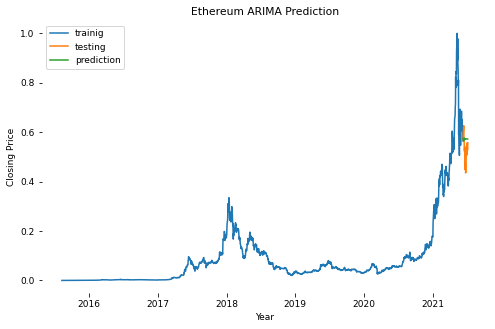

In [103]:
fig = plt.figure()
fig, ax = plt.subplots(figsize = (8,5))

ax.plot(closeTrain , label = "trainig")
ax.plot(closeTest, label = "testing")
ax.plot(Y_pred, label = "prediction")
ax.set_xlabel('Year')
ax.set_ylabel('Closing Price')
ax.set_title("Ethereum ARIMA Prediction")
ax.legend()

In [104]:
MSE = metrics.mean_squared_error(closeTest, Y_pred, squared=False)

RSquared = metrics.r2_score(closeTest, Y_pred)

RMSE = math.sqrt(MSE)

print("MSE:",MSE)
print("R Squared:",RSquared)
print("RMSE:",RMSE)

MSE: 0.07093323691827946
R Squared: -0.8935057584490729
RMSE: 0.26633294373449085


## Solana

### Loading Data

In [105]:
Solana = pd.read_csv("coin_Solana.csv")
Solana = Solana.drop(columns=['SNo','Name'])


Solana.isnull().sum()

Symbol       0
Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Marketcap    0
dtype: int64

### Data Preparation

In [106]:
import datetime as dt

Solana["Date"]=pd.to_datetime(Solana["Date"])
Solana["Date"] = Solana["Date"].dt.strftime('%Y-%m-%d')
Solana["Date"]=pd.to_datetime(Solana["Date"])

<AxesSubplot:xlabel='Date', ylabel='Close'>

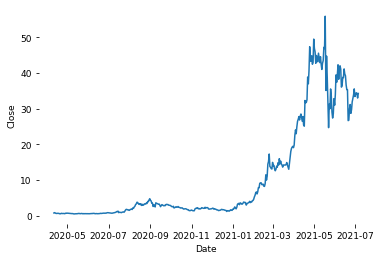

In [107]:
sns.lineplot(data=Solana, x="Date", y="Close")

In [108]:
data_week = [0 for i in range(7)]
closes = Solana['Close'].values

for i in closes[:-7]:
    data_week.append(i)

#### Three Week Average Calculation

In [111]:
three_avg = [0,0,0]
for i in range(len(closes)-3):
    three_avg.append((closes[i] + closes[i+1] + closes[i+2])/3)

print(len(three_avg))
print(len(closes))


Solana["Three_day_Avg"] = three_avg

452
452


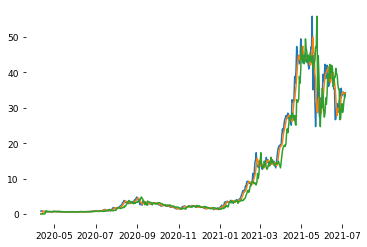

In [112]:
plt.plot(Solana['Date'] , closes)
plt.plot(Solana['Date'] , three_avg)
plt.plot(Solana['Date'] , data_week)

#### Week Average Calculation

In [113]:
Solana['Day'] = Solana['Date'].dt.day_name()

In [114]:
day = Solana['Day'].values

i = 0 
Sum = 0
while day[i] !='Monday':
    Sum+=closes[i]
    i+=1
WeekAvg = [ Sum/(i) for j in range(i)]
print(WeekAvg)
for j in range(i , len(closes)-7, 7):
    Avg = sum(closes[j : j +7])/7
    curr = [Avg for i in range(7)]
    WeekAvg+=curr
for j in range( len(WeekAvg) , len(closes)):
    WeekAvg.append(closes[i])
Solana["Week_Avg"] = WeekAvg

[0.8296627556180001, 0.8296627556180001]


#### Month Average Calculation

In [115]:
Solana['Month'] = Solana['Date'].dt.month

In [116]:
month = Solana['Month'].values
monthavg = []
Sum = closes[0]
n = 1
for i in range(1 , len(month)):
    if month[i] != month[i-1]:
        curr = [Sum/n for j in range(n)]
        monthavg+=curr
        Sum = 0
        n=0
   
    Sum+=closes[i]
    n+=1

curr = [Sum/n for j in range(n)]
monthavg+=curr


Solana['Month_Avg'] = monthavg

In [117]:
Solana['Year'] = Solana["Date"].dt.year
Solana['Month'] = Solana["Date"].dt.month
Solana['Day'] = Solana["Date"].dt.day

<AxesSubplot:title={'center':'Mean Solana Closing Price'}, xlabel='Date'>

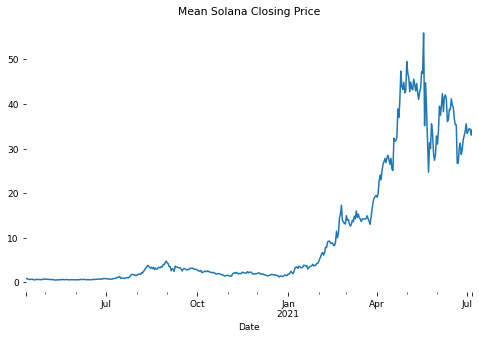

In [190]:
df_grouped = Solana.groupby(["Date"])['Close'].mean()
df_grouped.plot(figsize = (8,5) , title = "Mean Solana Closing Price")

<AxesSubplot:title={'center':'Mean Solana Closing Price'}, xlabel='Year'>

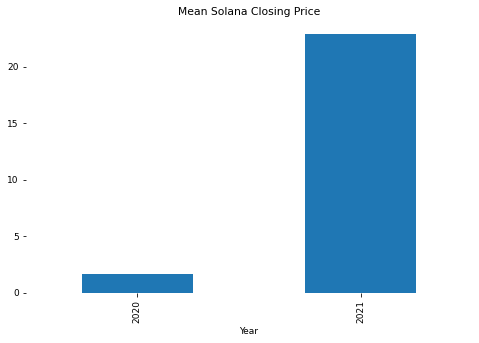

In [191]:
df_year = Solana.groupby(['Year'])['Close'].mean()
df_year.plot.bar(figsize = (8,5) ,title = "Mean Solana Closing Price")

#### Training/Testing Split

In [120]:
X= Solana.drop(columns=['Close','Open','High','Low','Symbol','Volume','Marketcap','Date'])
y= Solana['Close']

In [121]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

### Regression

#### Decision Tree Regression

In [122]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(min_samples_leaf=5,random_state=42)
tree_reg.fit(X_train, y_train)

y_train_pred = tree_reg.predict(X_train)

print("MSE:", metrics.mean_squared_error(y_train, y_train_pred, squared=False))
print("R Squared:", metrics.r2_score(y_train, y_train_pred))

MSE: 1.4319485552417979
R Squared: 0.9893184331822812


In [123]:
param_grid = {
    'splitter': ['best','random'],
    'max_depth': [1,2,3,4,5,6,7,8,9],
    'min_samples_split': [2,3,4,5,6],
    'min_samples_leaf': [1,2,3,4,5,6]
}
dtr_gs = GridSearchCV(estimator=DecisionTreeRegressor() , param_grid=param_grid)

dtr_gs.fit(X_train, y_train)

dtr_gs_best = dtr_gs.best_estimator_
dtr_gs_best.fit(X_train,y_train)

print('Best model: %s' % str(dtr_gs.best_params_))
print('Best score: %f' % dtr_gs.best_score_)
print('Best test auc: %f' % dtr_gs_best.score(X_test,y_test))

Best model: {'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 5, 'splitter': 'random'}
Best score: 0.982901
Best test auc: 0.977714


In [124]:
import math

tree_reg = DecisionTreeRegressor(max_depth = 6, min_samples_leaf = 1, min_samples_split = 4, splitter = 'best')
tree_reg.fit(X_train, y_train)

y_test_pred = tree_reg.predict(X_test)

MSE = metrics.mean_squared_error(y_test, y_test_pred, squared=False)

RSquared = metrics.r2_score(y_test, y_test_pred)

RMSE = math.sqrt(MSE)

print("MSE:",MSE)
print("R Squared:",RSquared)
print("RMSE:",RMSE)

MSE: 2.3125931709319243
R Squared: 0.9748154218776384
RMSE: 1.5207212666797043


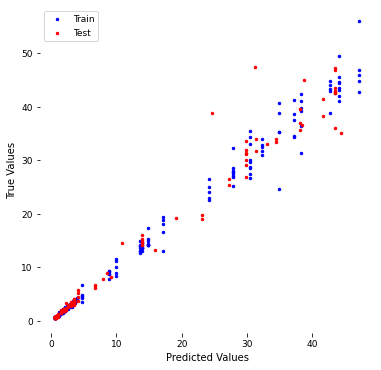

In [125]:
fig, ax = plt.subplots(figsize=(6, 6))

#mpl.rcParams['font.size'] = 5
mpl.rcParams['axes.linewidth'] = 0

ax.scatter(y_train_pred,y_train,color='blue', s=6, label = "Train")

ax.scatter(y_test_pred,y_test,color='red', s=6, label = "Test")


ax.set_xlabel("Predicted Values", fontsize=10)
ax.set_ylabel("True Values", fontsize=10)
ax.legend()

#### Linear Regression

In [126]:
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

y_train_pred = linear_reg.predict(X_train)
y_test_pred = linear_reg.predict(X_test)

MSE = metrics.mean_squared_error(y_test, y_test_pred, squared=False)

RSquared = metrics.r2_score(y_test, y_test_pred)

RMSE = math.sqrt(MSE)

print("MSE:",MSE)
print("R Squared:",RSquared)
print("RMSE:",RMSE)

MSE: 1.8357043002932116
R Squared: 0.9841312889184965
RMSE: 1.3548816554567455


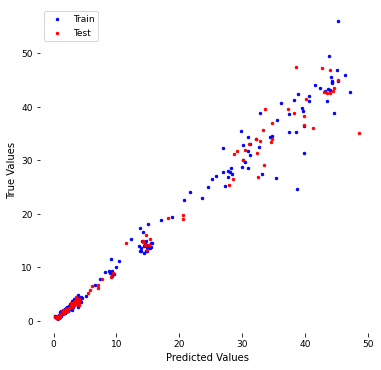

In [127]:
fig, ax = plt.subplots(figsize=(6, 6))

#mpl.rcParams['font.size'] =15
mpl.rcParams['axes.linewidth'] = 0

ax.scatter(y_train_pred,y_train,color='blue', s=6, label = "Train")

ax.scatter(y_test_pred,y_test,color='red', s=6, label = "Test")


ax.set_xlabel("Predicted Values", fontsize=10)
ax.set_ylabel("True Values", fontsize=10)
ax.legend()

#### Bayesian Ridge

In [128]:
from sklearn.linear_model  import BayesianRidge

br_reg = BayesianRidge()

br_reg .fit(X_train, y_train)

y_train_pred = br_reg.predict(X_train)
y_test_pred = br_reg.predict(X_test)

MSE = metrics.mean_squared_error(y_test, y_test_pred, squared=False)

RSquared = metrics.r2_score(y_test, y_test_pred)

RMSE = math.sqrt(MSE)

print("MSE:",MSE)
print("R Squared:",RSquared)
print("RMSE:",RMSE)

MSE: 1.830591726560135
R Squared: 0.9842195569243448
RMSE: 1.3529936165999215


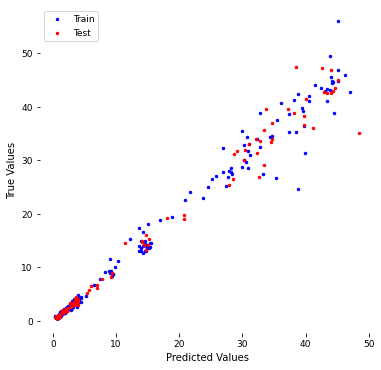

In [129]:
fig, ax = plt.subplots(figsize=(6, 6))

#mpl.rcParams['font.size'] = 5
mpl.rcParams['axes.linewidth'] = 0

ax.scatter(y_train_pred,y_train,color='blue', s=6, label = "Train")

ax.scatter(y_test_pred,y_test,color='red', s=6, label = "Test")


ax.set_xlabel("Predicted Values", fontsize=10)
ax.set_ylabel("True Values", fontsize=10)
ax.legend()

## Time Series (ARIMA)

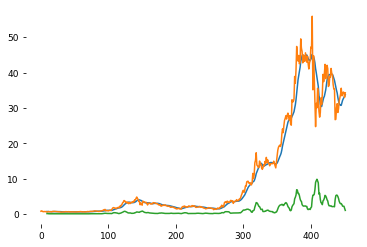

In [130]:
rollmean = Solana["Close"].rolling(10).mean()
plt.plot(rollmean)

plt.plot(Solana["Close"])

plt.plot(Solana["Close"].rolling(10).std()) #not stationary 

In [131]:
Close_scaled = Solana['Close']

Close_scaled = Close_scaled.array
Close_scaled.shape

(452,)

In [132]:
Close_scaled = Close_scaled.reshape(-1,1)

In [133]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(Close_scaled)

Close_scaled = scaler.transform(Close_scaled)

Close_scaled = Close_scaled.reshape(452,)

In [134]:
Close_scaled = pd.Series(Close_scaled)
Solana['Close_scaled'] = Close_scaled

In [135]:
Data_Arima = Solana.set_index('Date')
closeTrain = Data_Arima['Close_scaled'][:-12]
closeTest = Data_Arima['Close_scaled'][-12:]
print(len(closeTest))
print(len(closeTrain))

closeTrain

12
440


Date
2020-04-11    0.004721
2020-04-12    0.006629
2020-04-13    0.004740
2020-04-14    0.002647
2020-04-15    0.002372
                ...   
2021-06-20    0.628329
2021-06-21    0.471916
2021-06-22    0.473982
2021-06-23    0.533139
2021-06-24    0.553577
Name: Close_scaled, Length: 440, dtype: float64

In [136]:
adf = pmd.arima.ADFTest(alpha = 0.05)
adf.should_diff(Data_Arima['Close'])
#data is already station

(0.6386137452339302, True)

In [137]:
model = pmd.arima.auto_arima(closeTrain, error_action='ignore', seasonal = True)
model.fit(closeTrain)
y_pred = model.predict(n_periods = len(closeTest))
print(len(y_pred))
Y_pred = pd.DataFrame(y_pred , index = closeTest.index , columns = ["Pred"])      

12


<Figure size 432x288 with 0 Axes>

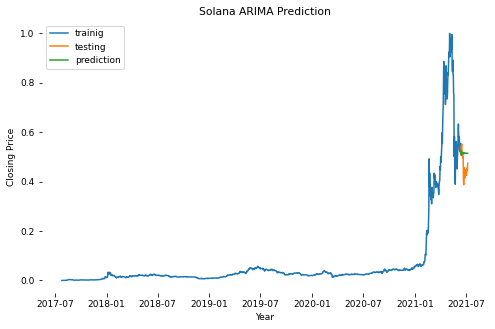

In [192]:
fig = plt.figure()
fig, ax = plt.subplots(figsize = (8,5))

ax.plot(closeTrain , label = "trainig")
ax.plot(closeTest, label = "testing")
ax.plot(Y_pred, label = "prediction")
ax.set_xlabel('Year')
ax.set_ylabel('Closing Price')
ax.set_title("Solana ARIMA Prediction")
ax.legend()

In [139]:
MSE = metrics.mean_squared_error(closeTest, Y_pred, squared=False)

RSquared = metrics.r2_score(closeTest, Y_pred)

RMSE = math.sqrt(MSE)

print("MSE:",MSE)
print("R Squared:",RSquared)
print("RMSE:",RMSE)

MSE: 0.041161412338938726
R Squared: -0.4032447662873875
RMSE: 0.20288275515414986


## Binance

### Loading Data

In [6]:
Binance = pd.read_csv("coin_BinanceCoin.csv")
Binance = Binance.drop(columns=['SNo','Name'])


Binance.isnull().sum()

Symbol       0
Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Marketcap    0
dtype: int64

### Data Preparation

In [141]:
import datetime as dt

Binance["Date"]=pd.to_datetime(Binance["Date"])
Binance["Date"] = Binance["Date"].dt.strftime('%Y-%m-%d')
Binance["Date"]=pd.to_datetime(Binance["Date"])

In [142]:
data_week = [0 for i in range(7)]
closes = Binance['Close'].values

for i in closes[:-7]:
    data_week.append(i)

#### Three Week Average Calculation

In [143]:
three_avg = [0,0,0]
for i in range(len(closes)-3):
    three_avg.append((closes[i] + closes[i+1] + closes[i+2])/3)

print(len(three_avg))
print(len(closes))


Binance["Three_day_Avg"] = three_avg

1442
1442


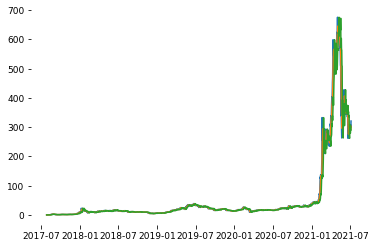

In [144]:
plt.plot(Binance['Date'] , closes)
plt.plot(Binance['Date'] , three_avg)
plt.plot(Binance['Date'] , data_week)

In [145]:
Binance['Day'] = Binance['Date'].dt.day_name()

#### Week Average Calculation

In [146]:
day = Binance['Day'].values

i = 0 
Sum = 0
while day[i] !='Monday':
    Sum+=closes[i]
    i+=1
WeekAvg = [ Sum/(i) for j in range(i)]
print(WeekAvg)
for j in range(i , len(closes)-7, 7):
    Avg = sum(closes[j : j +7])/7
    curr = [Avg for i in range(7)]
    WeekAvg+=curr
for j in range( len(WeekAvg) , len(closes)):
    WeekAvg.append(closes[i])
Binance["Week_Avg"] = WeekAvg

[0.10623339712619777, 0.10623339712619777, 0.10623339712619777, 0.10623339712619777, 0.10623339712619777]


#### Month Average Calculation

In [147]:
Binance['Month'] = Binance['Date'].dt.month

In [148]:
month = Binance['Month'].values
monthavg = []
Sum = closes[0]
n = 1
for i in range(1 , len(month)):
    if month[i] != month[i-1]:
        curr = [Sum/n for j in range(n)]
        monthavg+=curr
        Sum = 0
        n=0
   
    Sum+=closes[i]
    n+=1

curr = [Sum/n for j in range(n)]
monthavg+=curr


Binance['Month_Avg'] = monthavg

In [149]:
Binance['Year'] = Binance["Date"].dt.year
Binance['Month'] = Binance["Date"].dt.month
Binance['Day'] = Binance["Date"].dt.day

<AxesSubplot:title={'center':'Mean Binance Closing Price'}, xlabel='Date'>

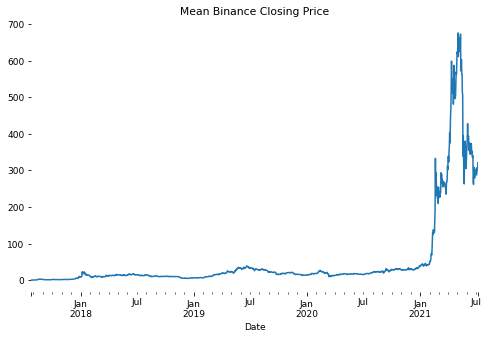

In [193]:
df_grouped = Binance.groupby(["Date"])['Close'].mean()
df_grouped.plot(figsize = (8,5) , title = "Mean Binance Closing Price") 

<AxesSubplot:title={'center':'Mean Binance Closing Price'}, xlabel='Year'>

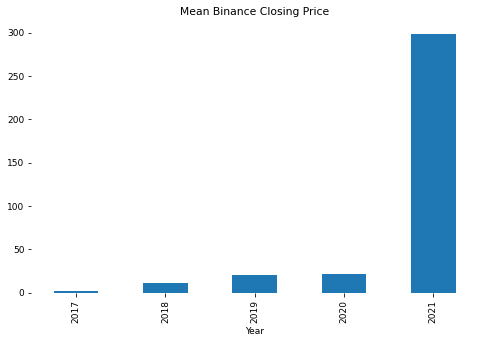

In [194]:
df_year = Binance.groupby(['Year'])['Close'].mean()
df_year.plot.bar(figsize = (8,5) ,title = "Mean Binance Closing Price")

#### Testing/Training Split

In [152]:
X= Binance.drop(columns=['Close','Open','High','Low','Symbol','Volume','Marketcap','Date'])
y= Binance['Close']

In [153]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

### Regression

#### Decision Tree Regression

In [154]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(min_samples_leaf=5,random_state=42)
tree_reg.fit(X_train, y_train)

y_train_pred = tree_reg.predict(X_train)

print("MSE:", metrics.mean_squared_error(y_train, y_train_pred, squared=False))
print("R Squared:", metrics.r2_score(y_train, y_train_pred))

MSE: 7.149748337195943
R Squared: 0.9963153563781363


In [155]:
param_grid = {
    'splitter': ['best','random'],
    'max_depth': [1,2,3,4,5,6,7,8,9],
    'min_samples_split': [2,3,4,5,6],
    'min_samples_leaf': [1,2,3,4,5,6]
}
dtr_gs = GridSearchCV(estimator=DecisionTreeRegressor() , param_grid=param_grid)

dtr_gs.fit(X_train, y_train)

dtr_gs_best = dtr_gs.best_estimator_
dtr_gs_best.fit(X_train,y_train)

print('Best model: %s' % str(dtr_gs.best_params_))
print('Best score: %f' % dtr_gs.best_score_)
print('Best test auc: %f' % dtr_gs_best.score(X_test,y_test))

Best model: {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 6, 'splitter': 'random'}
Best score: 0.992057
Best test auc: 0.991897


In [156]:
import math

tree_reg = DecisionTreeRegressor(max_depth = 6, min_samples_leaf = 1, min_samples_split = 4, splitter = 'best')
tree_reg.fit(X_train, y_train)

y_test_pred = tree_reg.predict(X_test)

MSE = metrics.mean_squared_error(y_test, y_test_pred, squared=False)

RSquared = metrics.r2_score(y_test, y_test_pred)

RMSE = math.sqrt(MSE)

print("MSE:",MSE)
print("R Squared:",RSquared)
print("RMSE:",RMSE)

MSE: 15.983893481006724
R Squared: 0.9789613754615621
RMSE: 3.9979861781910557


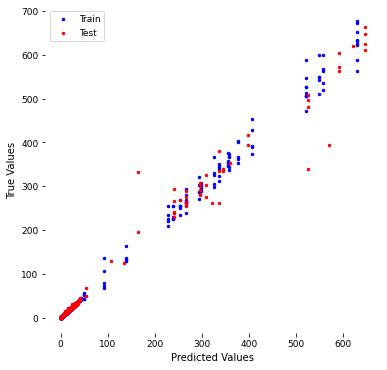

In [157]:
fig, ax = plt.subplots(figsize=(6, 6))

#mpl.rcParams['font.size'] = 5
mpl.rcParams['axes.linewidth'] = 0

ax.scatter(y_train_pred,y_train,color='blue', s=6, label = "Train")

ax.scatter(y_test_pred,y_test,color='red', s=6, label = "Test")


ax.set_xlabel("Predicted Values", fontsize=10)
ax.set_ylabel("True Values", fontsize=10)
ax.legend()

#### Linear Regression

In [158]:
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

y_train_pred = linear_reg.predict(X_train)
y_test_pred = linear_reg.predict(X_test)

MSE = metrics.mean_squared_error(y_test, y_test_pred, squared=False)

RSquared = metrics.r2_score(y_test, y_test_pred)

RMSE = math.sqrt(MSE)

print("MSE:",MSE)
print("R Squared:",RSquared)
print("RMSE:",RMSE)

MSE: 13.588885137992545
R Squared: 0.9847938298686543
RMSE: 3.6863105048262748


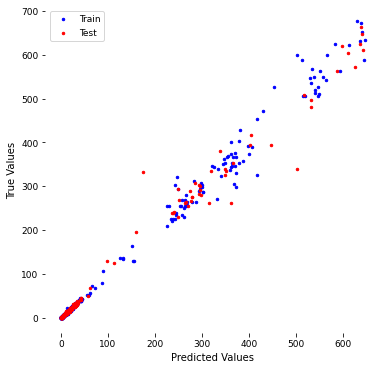

In [159]:
fig, ax = plt.subplots(figsize=(6, 6))

#mpl.rcParams['font.size'] = 5
mpl.rcParams['axes.linewidth'] = 0

ax.scatter(y_train_pred,y_train,color='blue', s=6, label = "Train")

ax.scatter(y_test_pred,y_test,color='red', s=6, label = "Test")


ax.set_xlabel("Predicted Values", fontsize=10)
ax.set_ylabel("True Values", fontsize=10)
ax.legend()

#### Bayesian Ridge

In [160]:
from sklearn.linear_model  import BayesianRidge

br_reg = BayesianRidge()

br_reg .fit(X_train, y_train)

y_train_pred = br_reg.predict(X_train)
y_test_pred = br_reg.predict(X_test)

MSE = metrics.mean_squared_error(y_test, y_test_pred, squared=False)

RSquared = metrics.r2_score(y_test, y_test_pred)

RMSE = math.sqrt(MSE)

print("MSE:",MSE)
print("R Squared:",RSquared)
print("RMSE:",RMSE)

MSE: 13.569331845123628
R Squared: 0.98483755925156
RMSE: 3.683657400617439


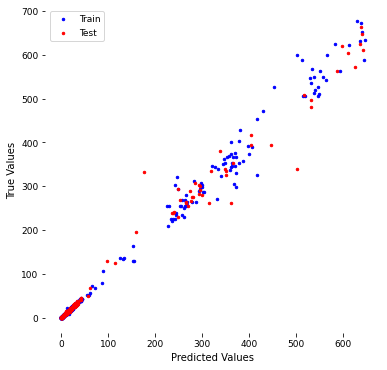

In [161]:
fig, ax = plt.subplots(figsize=(6, 6))

#mpl.rcParams['font.size'] = 5
mpl.rcParams['axes.linewidth'] = 0

ax.scatter(y_train_pred,y_train,color='blue', s=6, label = "Train")

ax.scatter(y_test_pred,y_test,color='red', s=6, label = "Test")


ax.set_xlabel("Predicted Values", fontsize=10)
ax.set_ylabel("True Values", fontsize=10)
ax.legend()

## Time Series (ARIMA)

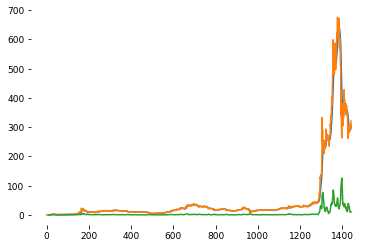

In [162]:
rollmean = Binance["Close"].rolling(10).mean()
plt.plot(rollmean)

plt.plot(Binance["Close"])

plt.plot(Binance["Close"].rolling(10).std()) #not stationary 

In [163]:
Close_scaled = Binance['Close']

Close_scaled = Close_scaled.array
Close_scaled.shape

(1442,)

In [164]:
Close_scaled = Close_scaled.reshape(-1,1)

In [165]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(Close_scaled)

Close_scaled = scaler.transform(Close_scaled)

Close_scaled = Close_scaled.reshape(1442,)

In [166]:
Close_scaled = pd.Series(Close_scaled)
Binance['Close_scaled'] = Close_scaled

In [167]:
Data_Arima = Binance.set_index('Date')
closeTrain = Data_Arima['Close_scaled'][:-25]
closeTest = Data_Arima['Close_scaled'][-25:]
print(len(closeTest))
print(len(closeTrain))

closeTrain

25
1417


Date
2017-07-26    0.000008
2017-07-27    0.000012
2017-07-28    0.000006
2017-07-29    0.000012
2017-07-30    0.000010
                ...   
2021-06-07    0.528743
2021-06-08    0.523845
2021-06-09    0.556015
2021-06-10    0.521154
2021-06-11    0.511903
Name: Close_scaled, Length: 1417, dtype: float64

In [168]:
adf = pmd.arima.ADFTest(alpha = 0.05)
adf.should_diff(Data_Arima['Close'])
#data is already station

(0.35544172177746247, True)

In [169]:
model = pmd.arima.auto_arima(closeTrain, error_action='ignore', seasonal = True)
model.fit(closeTrain)
y_pred = model.predict(n_periods = len(closeTest))
print(len(y_pred))
Y_pred = pd.DataFrame(y_pred , index = closeTest.index , columns = ["Pred"]) 

25


<Figure size 432x288 with 0 Axes>

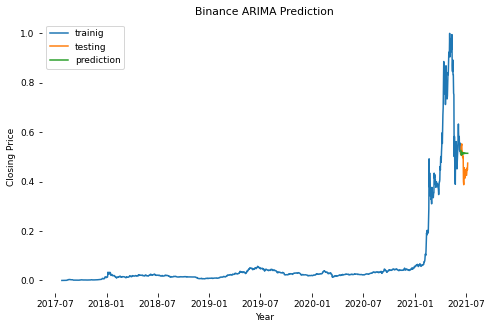

In [195]:
fig = plt.figure()
fig, ax = plt.subplots(figsize = (8,5))

ax.plot(closeTrain , label = "trainig")
ax.plot(closeTest, label = "testing")
ax.plot(Y_pred, label = "prediction")
ax.set_xlabel('Year')
ax.set_ylabel('Closing Price')
ax.set_title("Binance ARIMA Prediction")
ax.legend()

In [171]:
MSE = metrics.mean_squared_error(closeTest, Y_pred, squared=False)

RSquared = metrics.r2_score(closeTest, Y_pred)

RMSE = math.sqrt(MSE)

print("MSE:",MSE)
print("R Squared:",RSquared)
print("RMSE:",RMSE)

MSE: 0.06878829202849862
R Squared: -1.1603223621108847
RMSE: 0.26227522191106545
